In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sports-classification/EfficientNetB0-100-(224 X 224)- 98.40.h5
/kaggle/input/sports-classification/sports.csv
/kaggle/input/sports-classification/valid/bobsled/5.jpg
/kaggle/input/sports-classification/valid/bobsled/1.jpg
/kaggle/input/sports-classification/valid/bobsled/4.jpg
/kaggle/input/sports-classification/valid/bobsled/3.jpg
/kaggle/input/sports-classification/valid/bobsled/2.jpg
/kaggle/input/sports-classification/valid/hurdles/5.jpg
/kaggle/input/sports-classification/valid/hurdles/1.jpg
/kaggle/input/sports-classification/valid/hurdles/4.jpg
/kaggle/input/sports-classification/valid/hurdles/3.jpg
/kaggle/input/sports-classification/valid/hurdles/2.jpg
/kaggle/input/sports-classification/valid/snow boarding/5.jpg
/kaggle/input/sports-classification/valid/snow boarding/1.jpg
/kaggle/input/sports-classification/valid/snow boarding/4.jpg
/kaggle/input/sports-classification/valid/snow boarding/3.jpg
/kaggle/input/sports-classification/valid/snow boarding/2.jpg
/kaggl

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, DenseNet121, InceptionV3
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
import cv2
import seaborn as sns


In [18]:
dataset_path = "/kaggle/input/sports-classification"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")


bobsled: 138 images
hurdles: 136 images
snow boarding: 117 images
fly fishing: 134 images
luge: 127 images
sidecar racing: 133 images
ampute football: 112 images
volleyball: 142 images
billiards: 145 images
giant slalom: 150 images
tennis: 131 images
horse racing: 139 images
pole dancing: 112 images
figure skating women: 157 images
rollerblade racing: 159 images
fencing: 135 images
olympic wrestling: 167 images
golf: 157 images
ultimate: 97 images
harness racing: 147 images
football: 191 images
frisbee: 131 images
bungee jumping: 125 images
shot put: 149 images
ice climbing: 130 images
figure skating men: 128 images
rowing: 143 images
bike polo: 110 images
swimming: 157 images
judo: 150 images
axe throwing: 113 images
archery: 132 images
baseball: 174 images
wheelchair basketball: 106 images
log rolling: 128 images
lacrosse: 151 images
rock climbing: 141 images
horse jumping: 134 images
hydroplane racing: 108 images
formula 1 racing: 190 images
curling: 141 images
jousting: 118 images


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


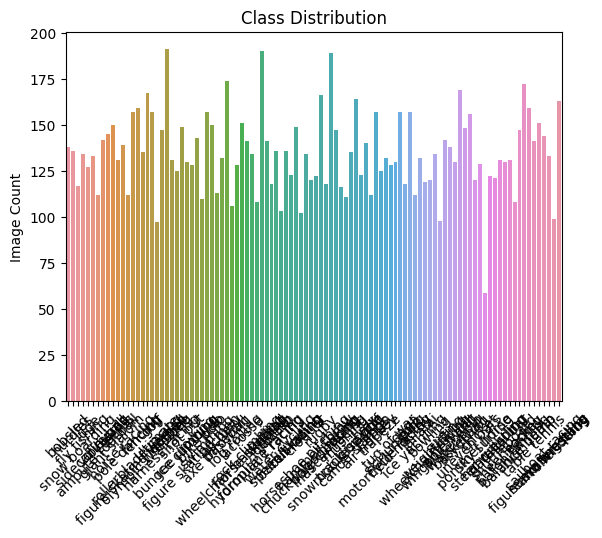

In [19]:
def analyze_dataset(path):
    class_counts = {}
    for cls in os.listdir(path):
        folder_path = os.path.join(path, cls)
        count = len(os.listdir(folder_path))
        class_counts[cls] = count
        print(f"{cls}: {count} images")
    
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.xticks(rotation=45)
    plt.title("Class Distribution")
    plt.ylabel("Image Count")
    plt.show()

analyze_dataset(train_path)


In [23]:
def get_generators(augment=False, return_aug_info=False):
    if augment:
        train_gen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        train_gen = ImageDataGenerator(rescale=1./255)

    val_gen = ImageDataGenerator(rescale=1./255)
    test_gen = ImageDataGenerator(rescale=1./255)

    train = train_gen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)
    val = val_gen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
    test = test_gen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

    if return_aug_info and augment:
        x_aug, _ = next(train)
        plt.figure(figsize=(10, 6))
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(x_aug[i])
            plt.axis('off')
        plt.suptitle("Sample Augmented Images")
        plt.tight_layout()
        plt.show()
        print(f"Augmented batch shape: {x_aug.shape}")

    return train, val, test


In [24]:
def build_model(base_model_class, input_shape=(224,224,3), num_classes=10):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
def train_and_evaluate(model, train, val, test, model_name):
    print(f"\nTraining {model_name}...")
    checkpoint = ModelCheckpoint(f"{model_name}.h5", save_best_only=True)
    earlystop = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(train, validation_data=val, epochs=20, callbacks=[checkpoint, earlystop])

    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f"Accuracy: {model_name}")
    plt.legend()
    plt.show()

    test_loss, test_acc = model.evaluate(test)
    print(f"Test Accuracy for {model_name}: {test_acc:.4f}")
    preds = model.predict(test)
    y_pred = np.argmax(preds, axis=1)
    y_true = test.classes
    print(classification_report(y_true, y_pred))
    return test_acc


In [26]:
model_classes = {
    "VGG19": VGG19,
    "DenseNet121": DenseNet121,
    "InceptionV3": InceptionV3
}



===== Training WITHOUT Augmentation =====
Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


I0000 00:00:1750847192.007745      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training VGG19_noaug...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1750847196.728367     128 service.cc:148] XLA service 0x7b909c0100d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750847196.729269     128 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750847197.143046     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/422 ━━━━━━━━━━━━━━━━━━━━ 39s 94ms/step - accuracy: 0.0234 - loss: 5.0142   

I0000 00:00:1750847205.438257     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 161ms/step - accuracy: 0.0412 - loss: 4.4841 - val_accuracy: 0.2360 - val_loss: 3.5285
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.1779 - loss: 3.4839 - val_accuracy: 0.4060 - val_loss: 2.6779
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.2699 - loss: 2.9358 - val_accuracy: 0.4900 - val_loss: 2.2473
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.3389 - loss: 2.5711 - val_accuracy: 0.5640 - val_loss: 1.9882
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.3791 - loss: 2.3702 - val_accuracy: 0.5840 - val_loss: 1.8086
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.4155 - loss: 2.2289 - val_accuracy: 0.5880 - val_loss: 1.6919
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.4222 - loss: 2.1767 - val_accuracy: 0.6140 - val_loss: 1.5805
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.4526 - loss: 2.0444 - val_accura

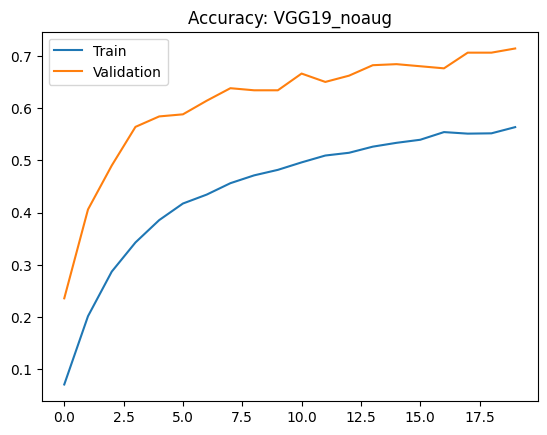

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.7301 - loss: 1.0131
Test Accuracy for VGG19_noaug: 0.7360
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      0.80      0.89         5
           2       1.00      0.60      0.75         5
           3       0.83      1.00      0.91         5
           4       0.80      0.80      0.80         5
           5       0.50      0.80      0.62         5
           6       0.75      0.60      0.67         5
           7       0.67      0.40      0.50         5
           8       0.80      0.80      0.80         5
           9       0.67      0.40      0.50         5
          10       0.80      0.80      0.80         5
          11       0.62      1.00      0.77         5
          12       0.40      0.40      0.40         5
          13       0.67      0.40      0.50         5
          14       1.00      0.40  

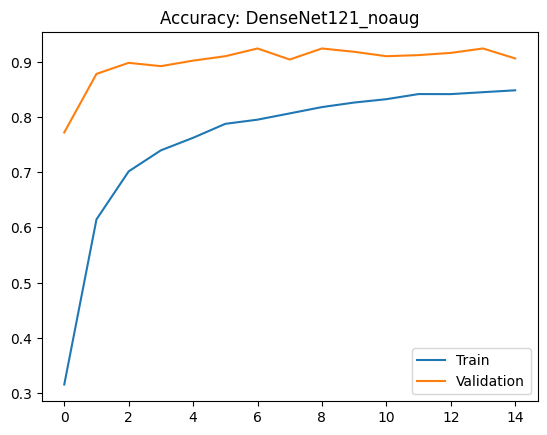

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9439 - loss: 0.1840
Test Accuracy for DenseNet121_noaug: 0.9300
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 839ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.71      1.00      0.83         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      0.60      0.75         5
          14       1.00      

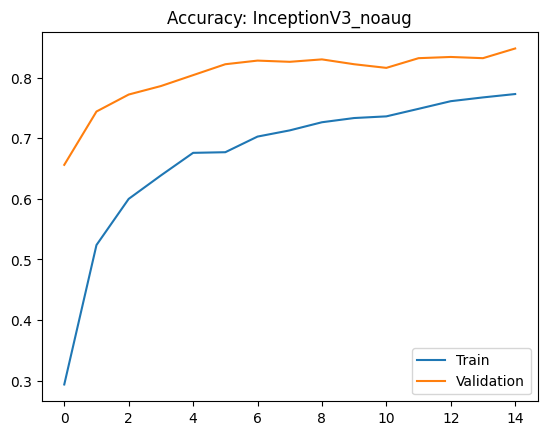

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8631 - loss: 0.4053
Test Accuracy for InceptionV3_noaug: 0.8500
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 497ms/step
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.50      0.60      0.55         5
           8       0.80      0.80      0.80         5
           9       1.00      1.00      1.00         5
          10       1.00      0.60      0.75         5
          11       1.00      1.00      1.00         5
          12       0.50      0.60      0.55         5
          13       1.00      1.00      1.00         5
          14       1.00      

In [27]:
noaug_results = {}
print("\n===== Training WITHOUT Augmentation =====")
train_gen, val_gen, test_gen = get_generators(augment=False)
for name, model_class in model_classes.items():
    model = build_model(model_class, num_classes=train_gen.num_classes)
    acc = train_and_evaluate(model, train_gen, val_gen, test_gen, f"{name}_noaug")
    noaug_results[name] = acc



===== Training WITH Augmentation =====
Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


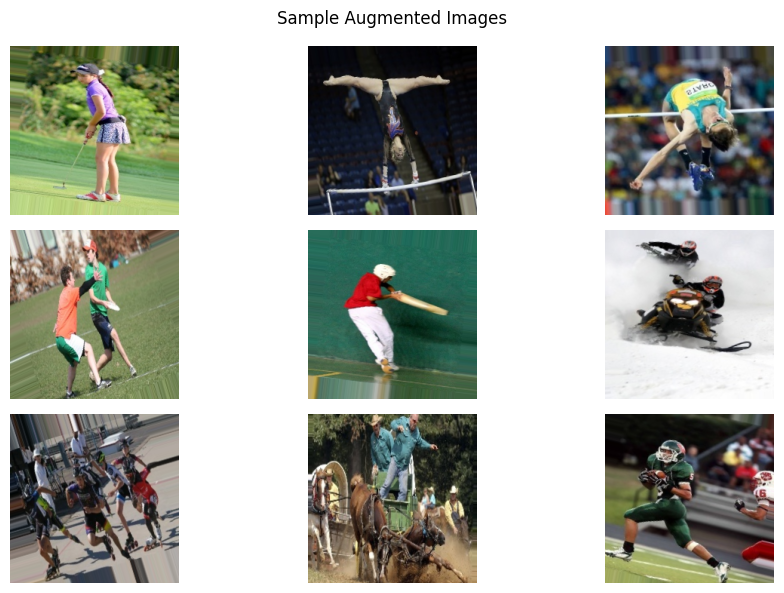

Augmented batch shape: (32, 224, 224, 3)

Training VGG19_aug...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 155s 360ms/step - accuracy: 0.0295 - loss: 4.5170 - val_accuracy: 0.1820 - val_loss: 3.7016
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 148s 350ms/step - accuracy: 0.1309 - loss: 3.7571 - val_accuracy: 0.3540 - val_loss: 2.9663
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 149s 353ms/step - accuracy: 0.2043 - loss: 3.2731 - val_accuracy: 0.4060 - val_loss: 2.5407
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 148s 350ms/step - accuracy: 0.2490 - loss: 3.0125 - val_accuracy: 0.4860 - val_loss: 2.3015
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 152s 359ms/step - accuracy: 0.2855 - loss: 2.8295 - val_accuracy: 0.4880 - val_loss: 2.0998
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 151s 357ms/step - accuracy: 0.3079 - loss: 2.7051 - val_accuracy: 0.5000 - val_loss: 1.9635
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 151s 357ms/step - accuracy: 0.3379 - loss: 2.5838 - val_accuracy: 0.5340 - val_loss: 1.8575
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 150s 355ms/step - accuracy: 0.3531 -

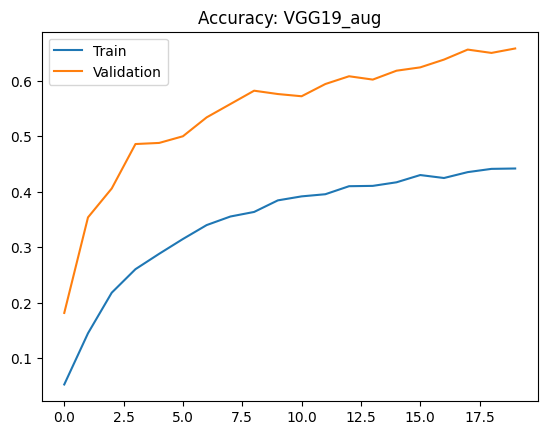

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.6684 - loss: 1.2202
Test Accuracy for VGG19_aug: 0.6500
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      0.60      0.75         5
           2       1.00      0.40      0.57         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.50      0.60      0.55         5
           6       1.00      1.00      1.00         5
           7       0.50      0.20      0.29         5
           8       0.75      0.60      0.67         5
           9       0.00      0.00      0.00         5
          10       0.44      0.80      0.57         5
          11       0.71      1.00      0.83         5
          12       0.67      0.40      0.50         5
          13       1.00      0.40      0.57         5
          14       1.00      0.20     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training DenseNet121_aug...
Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 196s 403ms/step - accuracy: 0.1337 - loss: 3.9496 - val_accuracy: 0.7260 - val_loss: 1.2914
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 147s 348ms/step - accuracy: 0.4888 - loss: 1.9026 - val_accuracy: 0.8100 - val_loss: 0.7475
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 145s 343ms/step - accuracy: 0.5921 - loss: 1.4291 - val_accuracy: 0.8560 - val_loss: 0.5744
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 145s 343ms/step - accuracy: 0.6366 - loss: 1.2649 - val_accuracy: 0.8600 - val_loss: 0.5223
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 145s 343ms/step - accuracy: 0.6630 - loss: 1.1412 - val_accuracy: 0.8800 - val_loss: 0.4338
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 146s 347ms/step - accuracy: 0.6806 - loss: 1.0653 - val_accuracy: 0.8840 - val_loss: 0.4331
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 146s 347ms/step - accuracy: 0.7063 - loss: 1.0095 - val_accuracy: 0.8880 - val_loss: 0.4113
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 146s 34

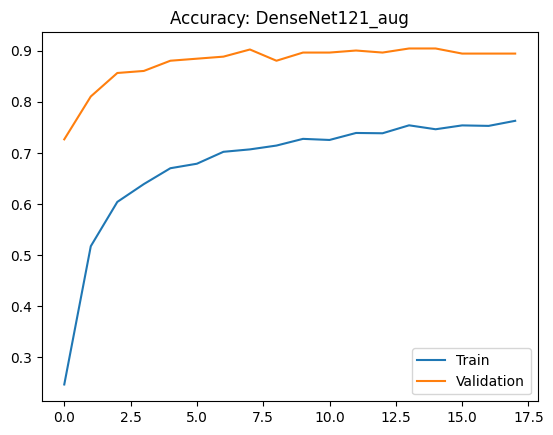

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9225 - loss: 0.2375
Test Accuracy for DenseNet121_aug: 0.9140
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 775ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         5
           7       0.60      0.60      0.60         5
           8       0.71      1.00      0.83         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      0.80      0.89         5
          14       1.00      1

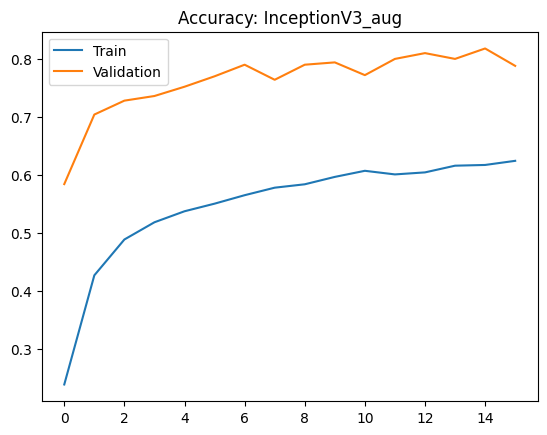

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8556 - loss: 0.4826
Test Accuracy for InceptionV3_aug: 0.8520
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 449ms/step
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.75      0.60      0.67         5
           5       0.71      1.00      0.83         5
           6       0.71      1.00      0.83         5
           7       1.00      0.40      0.57         5
           8       0.75      0.60      0.67         5
           9       0.83      1.00      0.91         5
          10       0.80      0.80      0.80         5
          11       1.00      1.00      1.00         5
          12       0.50      0.80      0.62         5
          13       0.83      1.00      0.91         5
          14       0.75      0

In [28]:
aug_results = {}
print("\n===== Training WITH Augmentation =====")
train_gen, val_gen, test_gen = get_generators(augment=True, return_aug_info=True)
for name, model_class in model_classes.items():
    model = build_model(model_class, num_classes=train_gen.num_classes)
    acc = train_and_evaluate(model, train_gen, val_gen, test_gen, f"{name}_aug")
    aug_results[name] = acc


In [29]:
print("\n🧮 Approximate count of augmented images per batch:")
augmented_batch, _ = next(train_gen)
print(f"Augmented batch contains {len(augmented_batch)} images")



🧮 Approximate count of augmented images per batch:
Augmented batch contains 32 images


In [30]:
print("\n--- FINAL ACCURACY COMPARISON ---")
print("Model\t\tNo-Aug\tAugmented")
for name in model_classes.keys():
    noaug = noaug_results.get(name, 0)
    aug = aug_results.get(name, 0)
    print(f"{name:<15} {noaug:.4f}\t{aug:.4f}")



--- FINAL ACCURACY COMPARISON ---
Model		No-Aug	Augmented
VGG19           0.7360	0.6500
DenseNet121     0.9300	0.9140
InceptionV3     0.8500	0.8520


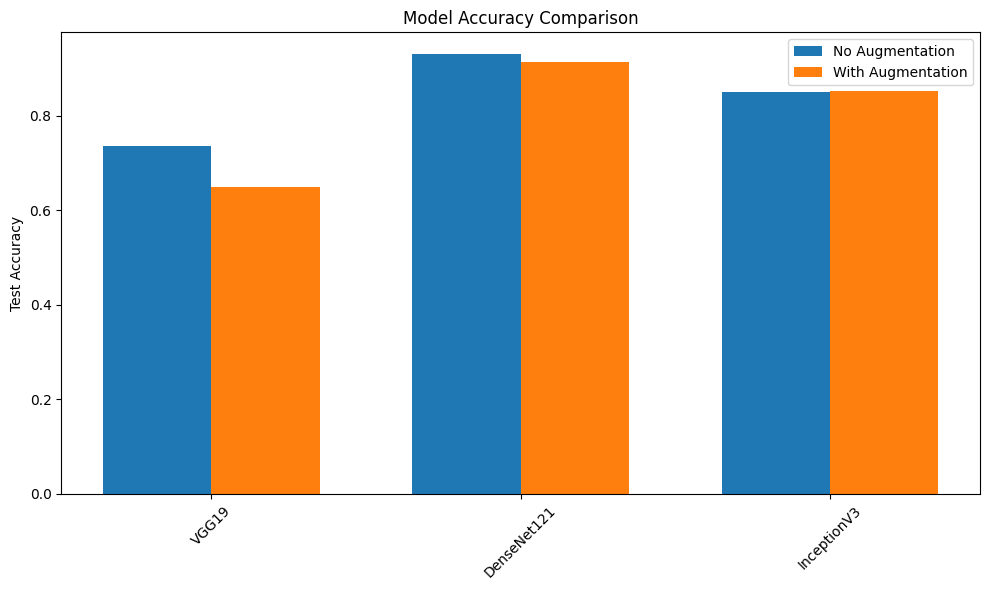

In [31]:
labels = list(model_classes.keys())
noaug_scores = [noaug_results[k] for k in labels]
aug_scores = [aug_results[k] for k in labels]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(10,6))
plt.bar(x - width/2, noaug_scores, width, label='No Augmentation')
plt.bar(x + width/2, aug_scores, width, label='With Augmentation')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

model = load_model("ResNet50_aug.h5")  # or any other trained model
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

pred = model.predict(x)
class_idx = np.argmax(pred)
train_gen, _, _ = get_generators(False)
labels = list(train_gen.class_indices.keys())
predicted_label = labels[class_idx]

plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
print("\n🔍 Welcome to Explainable AI - Visualizing Model Decisions")


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([
        model.input],
        [model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

last_conv_layer = 'conv5_block3_out'  # for ResNet50
heatmap = make_gradcam_heatmap(x, model, last_conv_layer)

img_orig = cv2.imread(image_path)
img_orig = cv2.resize(img_orig, (224, 224))
heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = heatmap_colored * 0.4 + img_orig

plt.imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM: Model Focus Area")
plt.axis('off')
plt.show()
